## Predicting Tags in StackOverflow questions Using Logistic Regession and Liner SVM

<ol> Tagging is one of the simplest ways to organize web content. Tagging makes search and indexing very easy. StackOverflow is website where developers ask questions or get answers. Based on questions the tags are generated.<br>
  
  Improving the correct prediction of the tags imporves quality of showing a question to the respective person/group.<br></ol>


### <ol>1. Dataset Overview:

<ol>
From the Kaggle competition, I obtained a training set with 6,034,195 StackExchange posts, consisting
of the<br>
1.Id - Unique identifier for each question<br>
2.Title - The question's title<br>
3.Body - The body of the question<br>
4.Tags - The tags associated with the question.
    

### <ol>1.1 Evaluation criteria :

The Evaluation metric used for this model is Mean F1-score 
F1-score is formulated below, where 𝑝 is precision and 𝑟 is recall, 𝑡𝑝 is true positive
frequency, 𝑓𝑝 is false positive frequency, and 𝑓𝑛 is false negative frequency.
<b>
    
>𝐹1 =
2*𝑝*𝑟 /
(𝑝+𝑟)
, 𝑝 =
𝑡𝑝 / 
(𝑡𝑝+𝑓𝑝) , 𝑟 =
𝑡𝑝 /
(𝑡𝑝+𝑓)

In [1]:
import sqlite3
import pandas as pd
import os
from sqlalchemy import create_engine
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import csv
from wordcloud import WordCloud
import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
import pickle
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,classification_report,precision_score,hamming_loss
import warnings
warnings.filterwarnings("ignore")

In [2]:
#creating a db file from csv
if not os.path.isfile("train.db"):
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 180000
    j=0 
    index_start=1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [12]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:00.060963


In [13]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("File not found")

Time taken to run this cell : 0:01:17.355776


In [14]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [15]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [19]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [21]:
df_no_dup.fillna('',inplace=True)
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
df_no_dup.head()

,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [23]:
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [24]:
if not os.path.isfile("train_no_dup.db"):
    disk_eng=create_engine("sqlite:///train_no_dup.db")
    no_dup=pd.DataFrame(df_no_dup,columns=['Title','Body','Tags'])
    no_dup.to_sql("no_dup_data",disk_eng)

In [2]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_data""", con)
    con.close()
    
    tag_data.drop(tag_data.index[0], inplace=True)
else:
    print("No file found with name in the given directory")
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


## 2. Analysis of Tags

### 2.1 Total number of unique tags

In [14]:
vectorizer=CountVectorizer(tokenizer= lambda x:x.split())
tag_dtm=vectorizer.fit_transform(tag_data["Tags"])

In [30]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [64]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 2.2 Number of times a tag appeared </h3>

In [65]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [66]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,groupwise-maximum,13
1,pisa-pdf,3
2,trn,1
3,filtering,1081
4,stringify,77


In [8]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

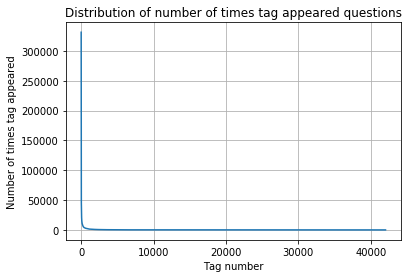

In [44]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

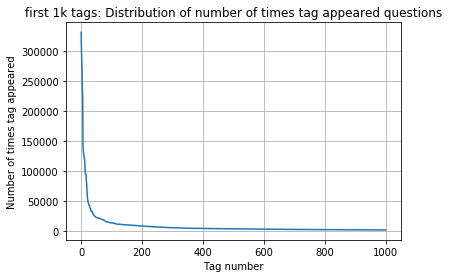

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [46]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

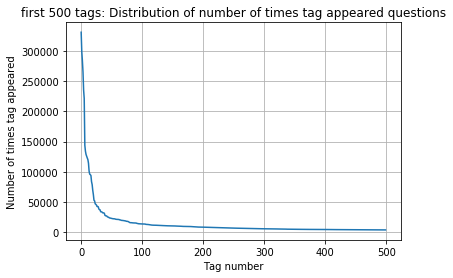

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [47]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

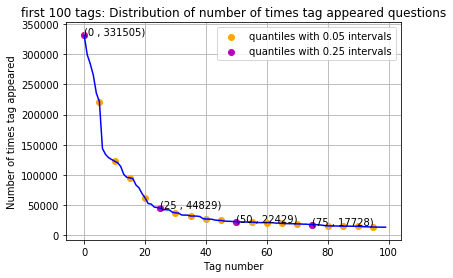

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [10]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [11]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 2.4 Tags Per Question </h3>

In [42]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [60]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


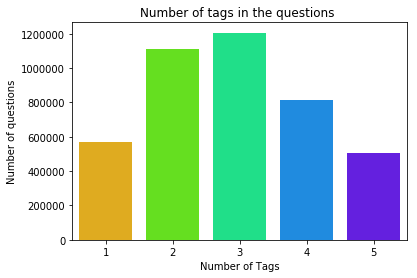

In [61]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### 2.5 Most frequent Tags:

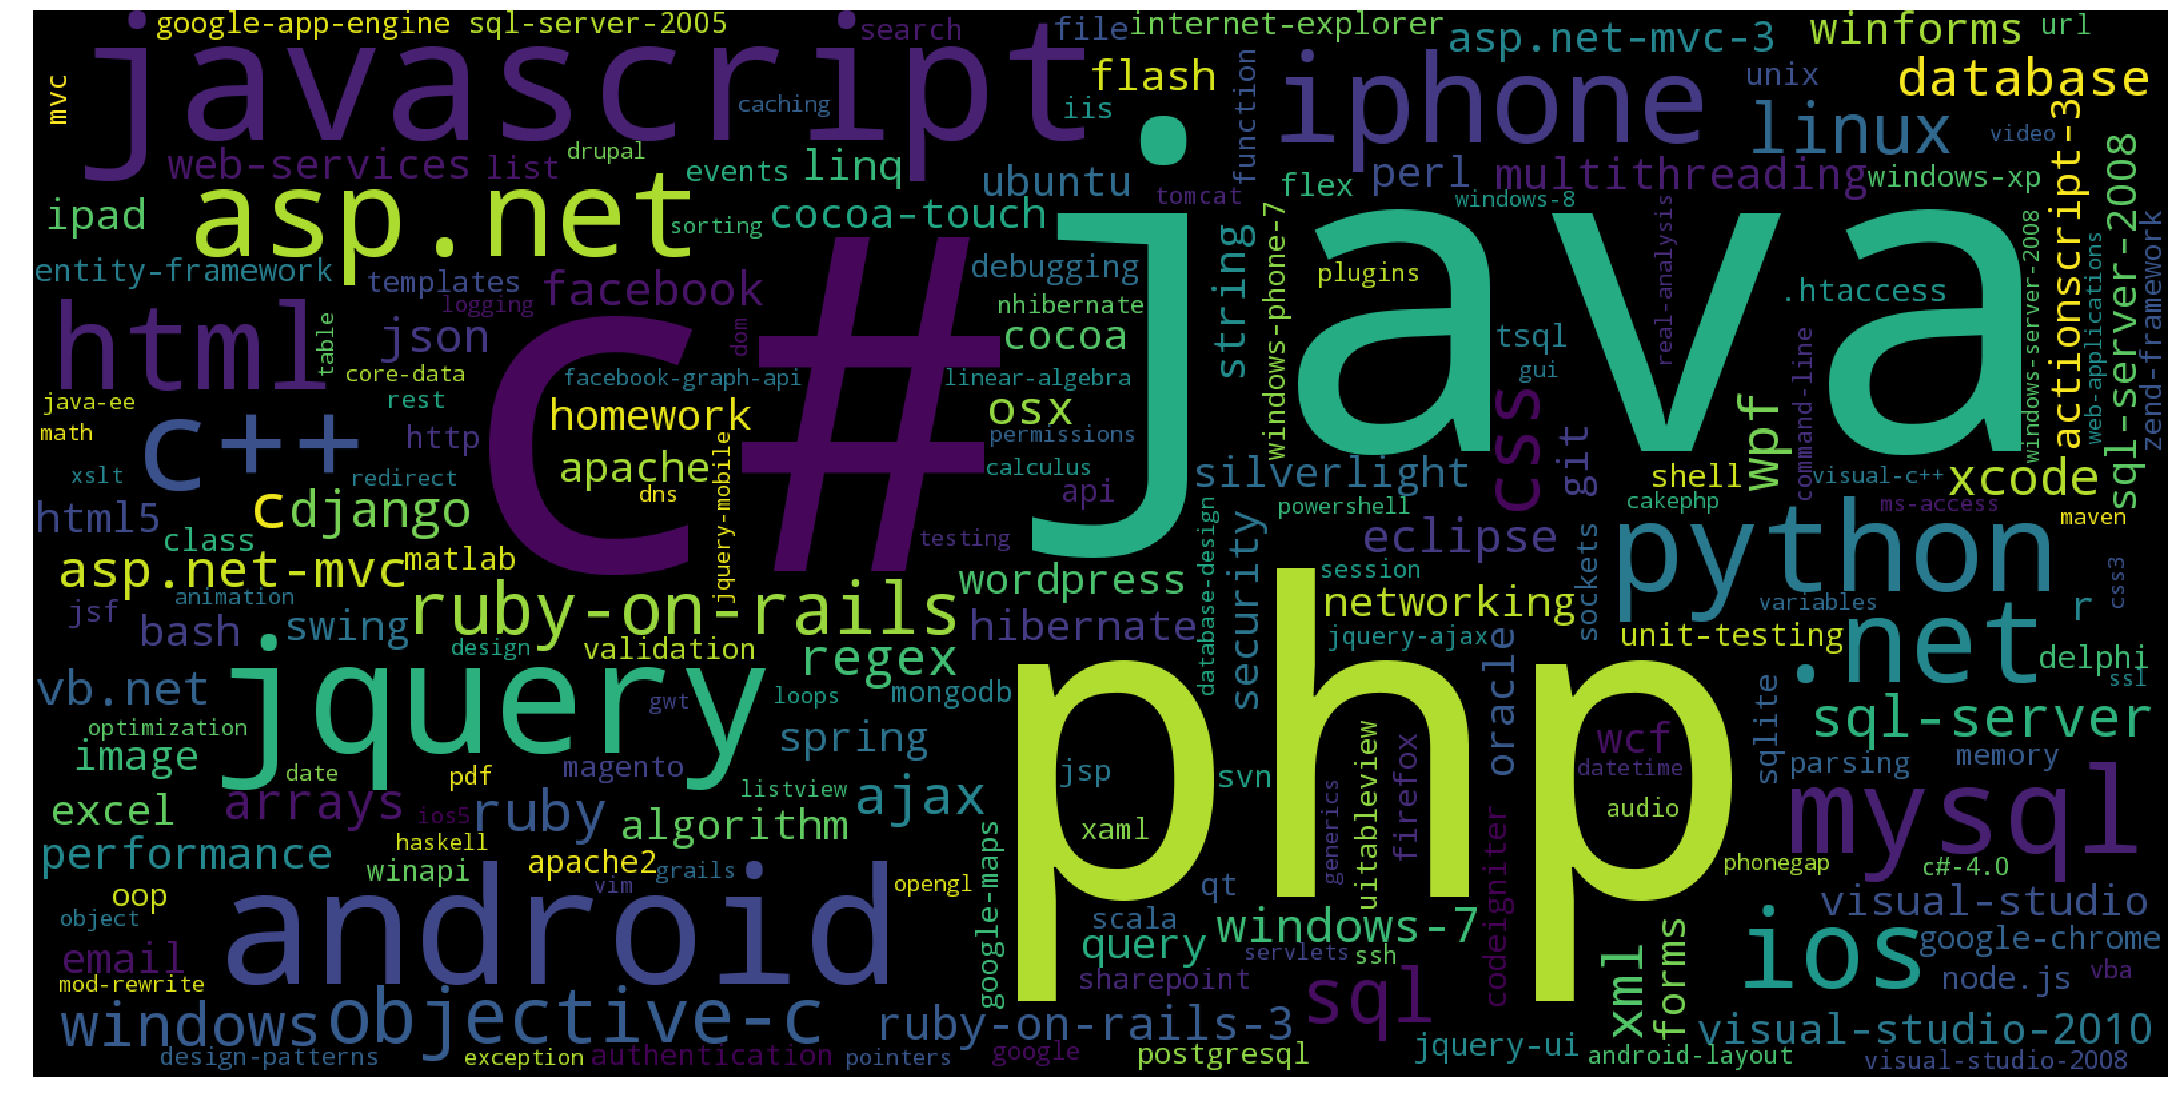

Time taken to run this cell : 0:00:04.572191


In [73]:
# Ploting word cloud
start = datetime.now()

# converting the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 2.6 The top 20 tags </h3>

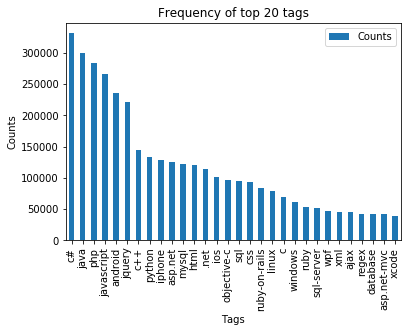

In [76]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 4.Cleaning and preprocessing of Questions </h3>

<h3> 4.1 Preprocessing </h3>

 - [x] Sampling 1M data points
 - [X] Separate out code-snippets from Body
 - [X] Remove Spcial characters from Question title and description (not in code)
 - [X] <b>Adding title to body 3 times</b>
 - [X] Remove stop words (Except 'C') 
 - [X] Remove HTML Tags 
 - [X] Convert all the characters into small letters
 - [X] Use SnowballStemmer to stem the words


In [5]:
def removeHtml(data):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',str(data))
    return cleantext
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')
    

In [5]:
def createDBConnection(db_file):
    try:
        con=sqlite3.connect(db_file)
        return con
    except Error as e:
        print(e)
    return None


In [6]:
def createDBTable(con,create_sql_table):
    try:
        c=con.cursor()
        c.execute(create_sql_table)
    except Error as e:
        print(e)

In [7]:
def checkTableExists(db_con):
    cursr=db_con.cursor()
    str="select name from sqlite_master where type='table'"
    table_names=cursr.execute(str)
    print("Tables in the database:")
    tables=table_names.fetchall()
    print(tables[0][0])
    return (len(tables))
    

In [8]:
def create_database_table(database,query):
    con=createDBConnection(database)
    if con is not None:
        createDBTable(con,query)
        checkTableExists(con)
        
    else:
        print("Error! cannot create database connection")
        con.close()
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the database:
QuestionsProcessed


In [28]:
read_db="train_no_dup.db"
write_db="Processed.db"
if os.path.isfile("train_no_dup.db"):
    con=createDBConnection(read_db)
    if con is not None:
        reader =con.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_data ORDER BY RANDOM() LIMIT 500000;")

if os.path.isfile("Processed.db"):
    conn=createDBConnection(write_db)
    if conn is not None:
        tables = checkTableExists(conn)
        writer=conn.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
    

Tables in the database:
QuestionsProcessed
Cleared All the rows


In [29]:
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:
    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=removeHtml(question.encode('utf-8'))

    title=title.encode('utf-8')
    #adding tittle 3 times to increase its weight
    question=str(title)+" "+str(title)+" "+str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))


number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
Avg. length of questions(Title+Body) before processing: 1166
Avg. length of questions(Title+Body) after processing: 397
Percent of questions containing code: 57


In [30]:
con.commit()
conn.commit()
con.close()
conn.close()

In [31]:
if os.path.isfile(write_db):
    conn_r = createDBConnection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('uiscrollview uiimageview gestur use transitionfromview act strang uiscrollview uiimageview gestur use transitionfromview act strang uiscrollview uiimageview gestur use transitionfromview act strang made view hold uiscrollview add sever uiimageview contain imag ok far good method flipimag part rebuildscrollview behavior follow click first imag scrollview effect way want mean frontimag turn around show empti white back text middl click second imag imag turn back complet empti show grey background window scroll imag still show front imag expect click third imag great current layout backview noth backview let run click last imag idea what go wrong edit new find doubl amount pictur front backview place flip one pictur amp backview actual correct one empti empti empti',)
----------------------------------------------------------------------------------------------------
('save modelform error user messag could creat data valid save modelform error user messag c

In [9]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = createDBConnection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [10]:
preprocessed_data.head(3)

,question,tags
0,produc xml output use wcf servic produc xml ou...,c# wcf web-services
1,uiscrollview uiimageview gestur use transition...,objective-c ios uiview uiscrollview uiimageview
2,save modelform error user messag could creat d...,django django-models django-forms


In [11]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 499999
number of dimensions : 2


In [12]:
preprocessed_data.to_pickle("preprocessed_data.pkl")

In [3]:
processed_data=pd.read_pickle("preprocessed_data.pkl")

Converting string Tags to multiple output variables

In [4]:
vectorizer=CountVectorizer(tokenizer= lambda x:x.split(" "),binary='true')
multilabel_y=vectorizer.fit_transform(processed_data['tags'])

In [5]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

<ol>Selecting only 500 labels which covers the ~90% of the tags

In [6]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=processed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

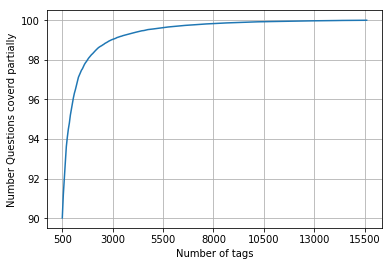

with  5500 tags we are covering  99.033 % of questions


In [7]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [27]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 49933 out of  499999


### 5.Featurization of data

### 5.1 Splitting the data into train and test

In [28]:
total_size=processed_data.shape[0]
train_size=int(0.80*total_size)

x_train=processed_data.head(train_size)
x_test=processed_data.tail(total_size-train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [29]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (399999, 500)
Number of data points in test data : (100000, 500)


### 5.2 Featurizing the data using BOW

In [30]:
vectorizer=CountVectorizer(ngram_range=(1,4),max_features=200000,min_df=0.00009,tokenizer=lambda x:x.split())
X_train_multilabel=vectorizer.fit_transform(x_train['question'])
X_test_multilabel=vectorizer.transform(x_test['question'])

In [18]:
print(X_train_multilabel.shape)

(399999, 91777)


In [2]:
X_train_multilabel=pickle.load(open("train_vect_bow_t500.sav" ,'rb'))
X_test_multilabel=pickle.load(open("test_vect_bow_t500.sav",'rb'))
y_train=pickle.load(open("Y_train_t500.sav",'rb'))
y_test=pickle.load(open("Y_test_t500.sav",'rb'))

### 6. Logistic Regression OVR

In [3]:
classfier_LR = OneVsRestClassifier(LogisticRegression(penalty='l1',C=0.1), n_jobs=-1)
classfier_LR.fit(X_train_multilabel,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)

In [4]:
filename="classifier_LR.sav"
pickle.dump(classfier_LR,open(filename,'wb'))

In [9]:
predictions = classfier_LR.predict(X_test_multilabel)
print("Accuracy :",accuracy_score(y_test, predictions))
print("Hamming loss ",hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (classification_report(y_test, predictions))

Accuracy : 0.23812
Hamming loss  0.0028254
Micro-average quality numbers
Precision: 0.7033, Recall: 0.3773, F1-measure: 0.4911
Macro-average quality numbers
Precision: 0.5299, Recall: 0.3006, F1-measure: 0.3720
             precision    recall  f1-score   support

          0       0.65      0.32      0.43      7818
          1       0.80      0.48      0.60      7159
          2       0.85      0.57      0.69      6720
          3       0.76      0.46      0.57      6221
          4       0.95      0.79      0.86      5556
          5       0.86      0.65      0.74      5223
          6       0.72      0.36      0.48      3400
          7       0.89      0.63      0.74      3212
          8       0.71      0.42      0.53      3144
          9       0.80      0.44      0.57      2959
         10       0.87      0.62      0.72      2865
         11       0.54      0.21      0.31      2840
         12       0.56      0.15      0.24      2803
         13       0.63      0.31      0.41    

#### Observations:


<ol>Logistic regression gave micro averaged F1_score of <b>0.491</b>

## 7.SGD classifier-OvR with hinge loss

In [14]:
start = datetime.now()
classifier_SVM = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier_SVM.fit(X_train_multilabel, y_train)
print("Time Taken: " ,datetime.now()-start)

Time Taken:  0:12:33.325333


In [15]:
filename="classifier_SVM.sav"
pickle.dump(classifier_SVM,open(filename,'wb'))

In [16]:
predictions_svm = classifier_SVM.predict(X_test_multilabel)
print("Accuracy :",accuracy_score(y_test, predictions_svm))
print("Hamming loss ",hamming_loss(y_test,predictions_svm))


precision = precision_score(y_test, predictions_svm, average='micro')
recall = recall_score(y_test, predictions_svm, average='micro')
f1 = f1_score(y_test, predictions_svm, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_svm, average='macro')
recall = recall_score(y_test, predictions_svm, average='macro')
f1 = f1_score(y_test, predictions_svm, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (classification_report(y_test, predictions_svm))

Accuracy : 0.13743
Hamming loss  0.00475546
Micro-average quality numbers
Precision: 0.3739, Recall: 0.4686, F1-measure: 0.4160
Macro-average quality numbers
Precision: 0.2816, Recall: 0.3900, F1-measure: 0.3245
             precision    recall  f1-score   support

          0       0.45      0.45      0.45      7818
          1       0.58      0.58      0.58      7159
          2       0.65      0.63      0.64      6720
          3       0.53      0.55      0.54      6221
          4       0.82      0.84      0.83      5556
          5       0.69      0.71      0.70      5223
          6       0.46      0.47      0.46      3400
          7       0.69      0.71      0.70      3212
          8       0.52      0.53      0.52      3144
          9       0.48      0.53      0.50      2959
         10       0.60      0.69      0.64      2865
         11       0.33      0.32      0.32      2840
         12       0.25      0.23      0.24      2803
         13       0.39      0.43      0.41   

### 7.1 Tuning alpha in SGD classifier-OvR

In [9]:
params={'estimator__alpha':[0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001]}
ovr_model=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
alpha_tuning=GridSearchCV(ovr_model,param_grid=params,cv=2,n_jobs=-1,scoring='f1_micro')
alpha_tuning.fit(X_train_multilabel,y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__alpha': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [2]:
alpha_tuning=pickle.load(open("alpha_tuning.sav",'rb'))

In [7]:
alpha_tuning.best_estimator_

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
          n_jobs=1)

### 7.2 Plotting alpha vs F1_micro score

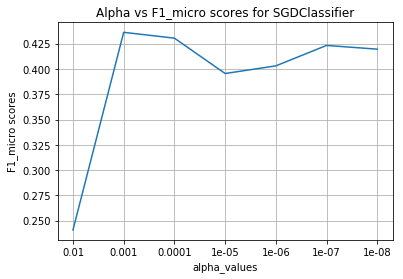

In [37]:
scores_data=[]
alpha_data=[0,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001]
for a in alpha_tuning.grid_scores_:
    scores_data.append(a[1])
fig, ax = plt.subplots()
ax.plot(scores_data)
ax.set_xticklabels(alpha_data)
plt.xlabel("alpha_values")
plt.ylabel("F1_micro scores")
plt.title("Alpha vs F1_micro scores for SGDClassifier")
plt.grid()
plt.show()

<ol>At alpha value <b>0.001</b> we have highest F1_micro score of <b>0.434</b>

<ol> <h3> Conclusions:</h3>
    <li>Becasue of computaional power limit I have taken half a million records with 500 tags(which covers ~90% of total tags)</li>
    <li>Logistic Regression with One vs Rest classifier gave highest F1_micro averaged score of <b>0.491</b></li>
    <li>With SGD classifier we are only able to achieve <b>0.434</b> of F1_micro while aplha value is at <b>0.001</b></li>
        
</ol> 